In [65]:
#importing cv2 and matplotlid
import cv2
import matplotlib.pyplot as plt
import numpy as np

#loading image
img =  cv2.imread("./happy_boy.jpg") #loading image
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

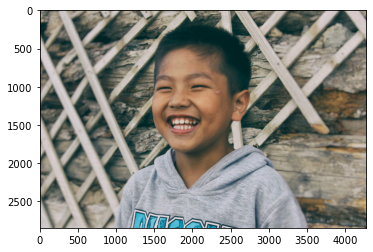

In [66]:
#showing image using plt 
color_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(color_img) 

In [67]:
#importing deepface library and DeepFace
from deepface import DeepFace


#this analyses the given image and gives values
#when we use this for 1st time, it may give many errors and some google drive links to download some '.h5' and zip files, download and save them in the location where it shows that files are missing.
prediction = DeepFace.analyze(color_img)

Action: race: 100%|██████████| 4/4 [00:00<00:00,  5.20it/s]  


In [68]:
print(prediction[0]['age'],
prediction[0]['dominant_race'],
prediction[0]['dominant_emotion'],
prediction[0]['dominant_gender'])

27 asian happy Man


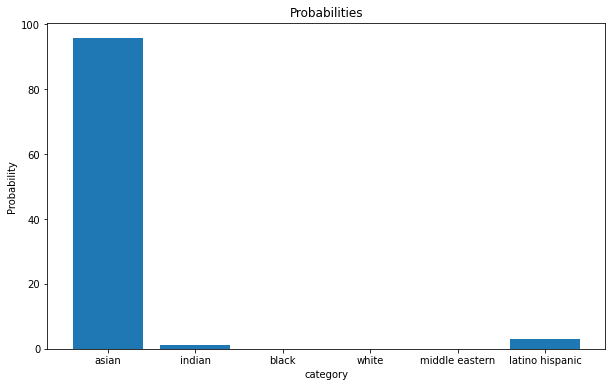

In [70]:
# Extract emotion probabilities
probabilities = prediction[0]['race']

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(probabilities.keys(), probabilities.values())
plt.xlabel('category')
plt.ylabel('Probability')
plt.title('Probabilities')
plt.show()

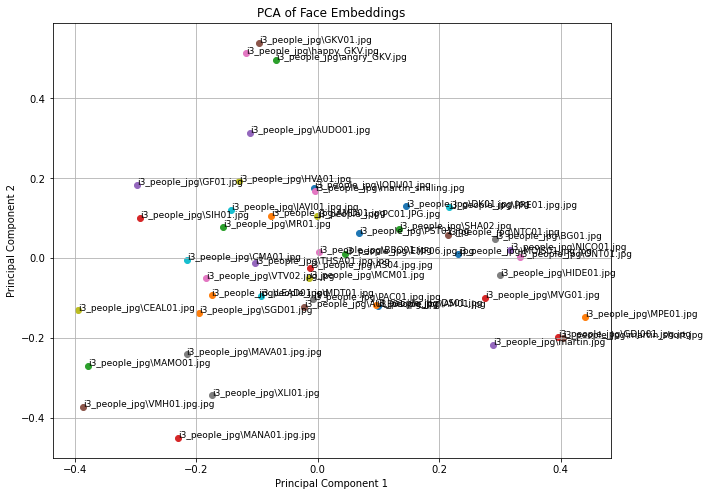

Explained variance by component: [0.05551739 0.04821468]


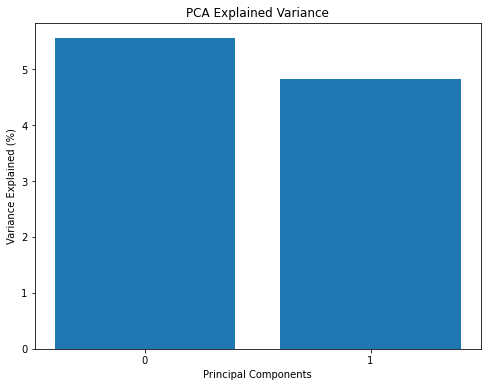

In [64]:
from deepface import DeepFace
import cv2
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


image_dir = './i3_people_jpg'

# Step 1: List all JPEG images in the specified directory
image_paths = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.jpg')]
# List to store embeddings for all images
all_embeddings = []

# List to store image names
image_names = []

# Loop through each image
for image_path in image_paths:
    # Load the image using OpenCV
    img = cv2.imread(image_path)
    
    # Detect faces and retrieve embeddings using DeepFace
    embeddings = DeepFace.represent(img, enforce_detection = False)
    
    # Extract the embedding for the first detected face (assuming there's only one face per image)
    embedding = embeddings[0]['embedding']
    
    # Append the embedding to the list
    all_embeddings.append(embedding)
    
    # Append the image name to the list
    image_names.append(image_path.split("/")[-1])  # Extract the image name from the path

# Convert the list of embeddings to a numpy array
all_embeddings = np.array(all_embeddings)
# Perform PCA to reduce to 2 dimensions for easy visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(all_embeddings)

# Plotting the reduced embeddings
plt.figure(figsize=(10, 8))
for i, name in enumerate(image_names):
    plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1])
    plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], name, fontsize=9)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Face Embeddings')
plt.grid(True)
plt.show()

# Displaying the explained variance
print("Explained variance by component:", pca.explained_variance_ratio_)

# Plotting the explained variance
plt.figure(figsize=(8, 6))
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_ * 100)
plt.xlabel('Principal Components')
plt.ylabel('Variance Explained (%)')
plt.title('PCA Explained Variance')
plt.xticks(range(len(pca.explained_variance_ratio_)))
plt.show()


In [47]:
#compute distance_matrix
import os
import pandas as pd
import numpy as np
from deepface import DeepFace
from tqdm import tqdm

# Define the directory containing your images
image_dir = './all'

# Step 1: List all JPEG images in the specified directory
image_paths = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.jpg')]
#image_paths = image_paths[1:10]
# Initialize an empty DataFrame to hold the distances
distance_matrix = pd.DataFrame(index=image_paths, columns=image_paths, dtype=float)

# Step 2: Loop through each pair of images and compute their distance
for i, img_path1 in enumerate(image_paths):
    for img_path2 in tqdm(image_paths[i+1:]):  # Compare each pair only once
        #print(img_path1, img_path2)
        try:
            # Using DeepFace to find the distance between two images, ensuring full paths are used
            result = DeepFace.verify(img_path1, img_path2, enforce_detection=False, distance_metric="cosine")
            
            # Extract the distance and store it in the matrix
            distance = result["distance"]
            distance_matrix.at[img_path1, img_path2] = distance
            distance_matrix.at[img_path2, img_path1] = distance
            
        except Exception as e:
            print(f"Error processing image pair: {img_path1}, {img_path2}. Error: {e}")

# Fill diagonal with 0s, as the distance of an image to itself is 0
np.fill_diagonal(distance_matrix.values, 0)

#print(distance_matrix)


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]
0it [00:00, ?it/s]


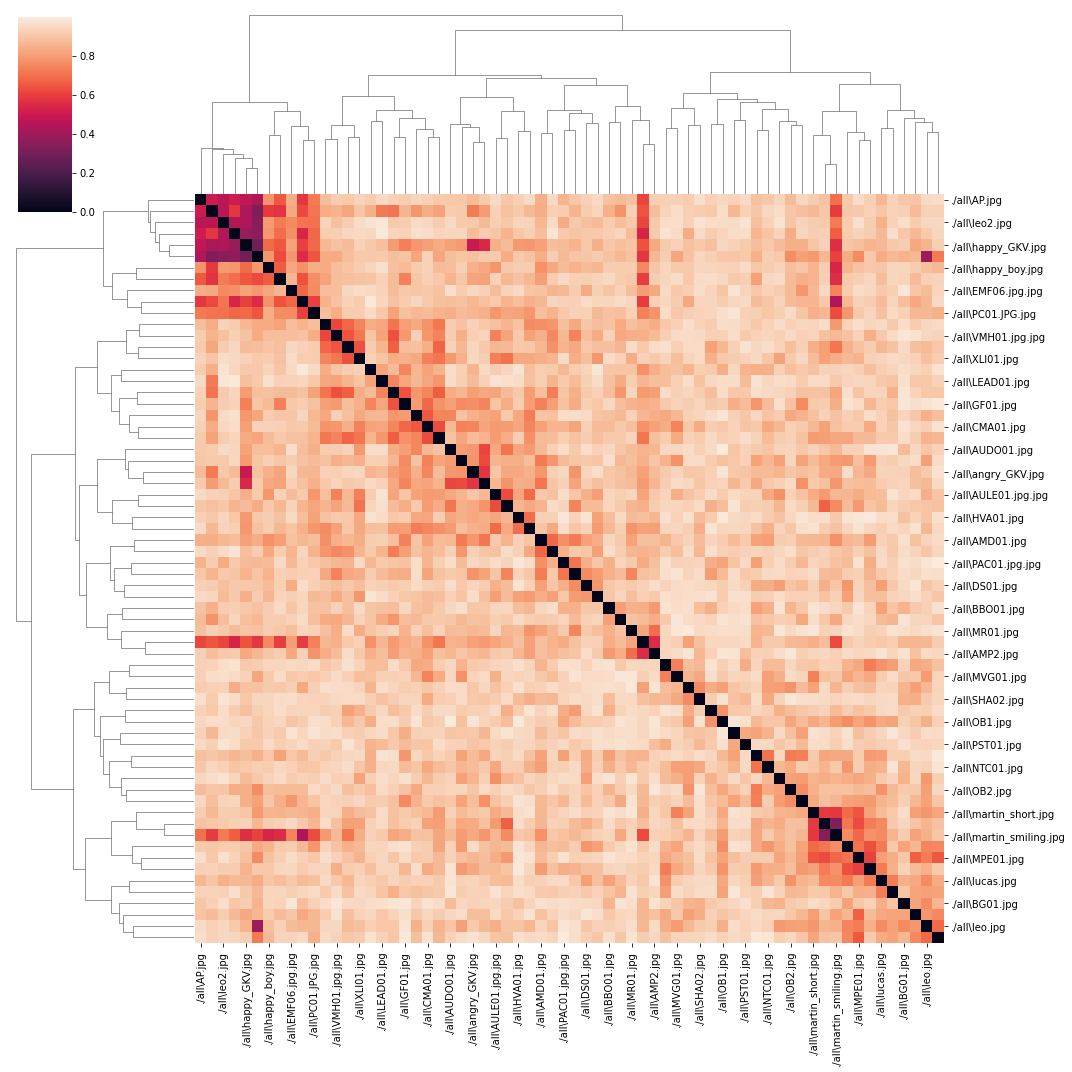

In [48]:
#state of the art heatmap
import pandas as pd
import seaborn as sns
import scipy.spatial as sp
import scipy.cluster.hierarchy as hc
import matplotlib.pyplot as plt
# Assuming 'distance_matrix' is your precomputed cosine distance matrix as a pandas DataFrame
# Make sure 'distance_matrix' is symmetric and its diagonal filled with 0s

# Convert the distance matrix from square to condensed form
# Note: This step is necessary because 'hc.linkage' requires distances in condensed form
# However, since our 'distance_matrix' is already a distance matrix, we skip directly to linkage computation

# Compute the linkage matrix
linkage = hc.linkage(sp.distance.squareform(distance_matrix), method="ward")

# Use the linkage matrix for both rows and columns in the clustermap
sns.clustermap(distance_matrix, row_linkage=linkage, col_linkage=linkage, figsize=(15, 15))

plt.show()


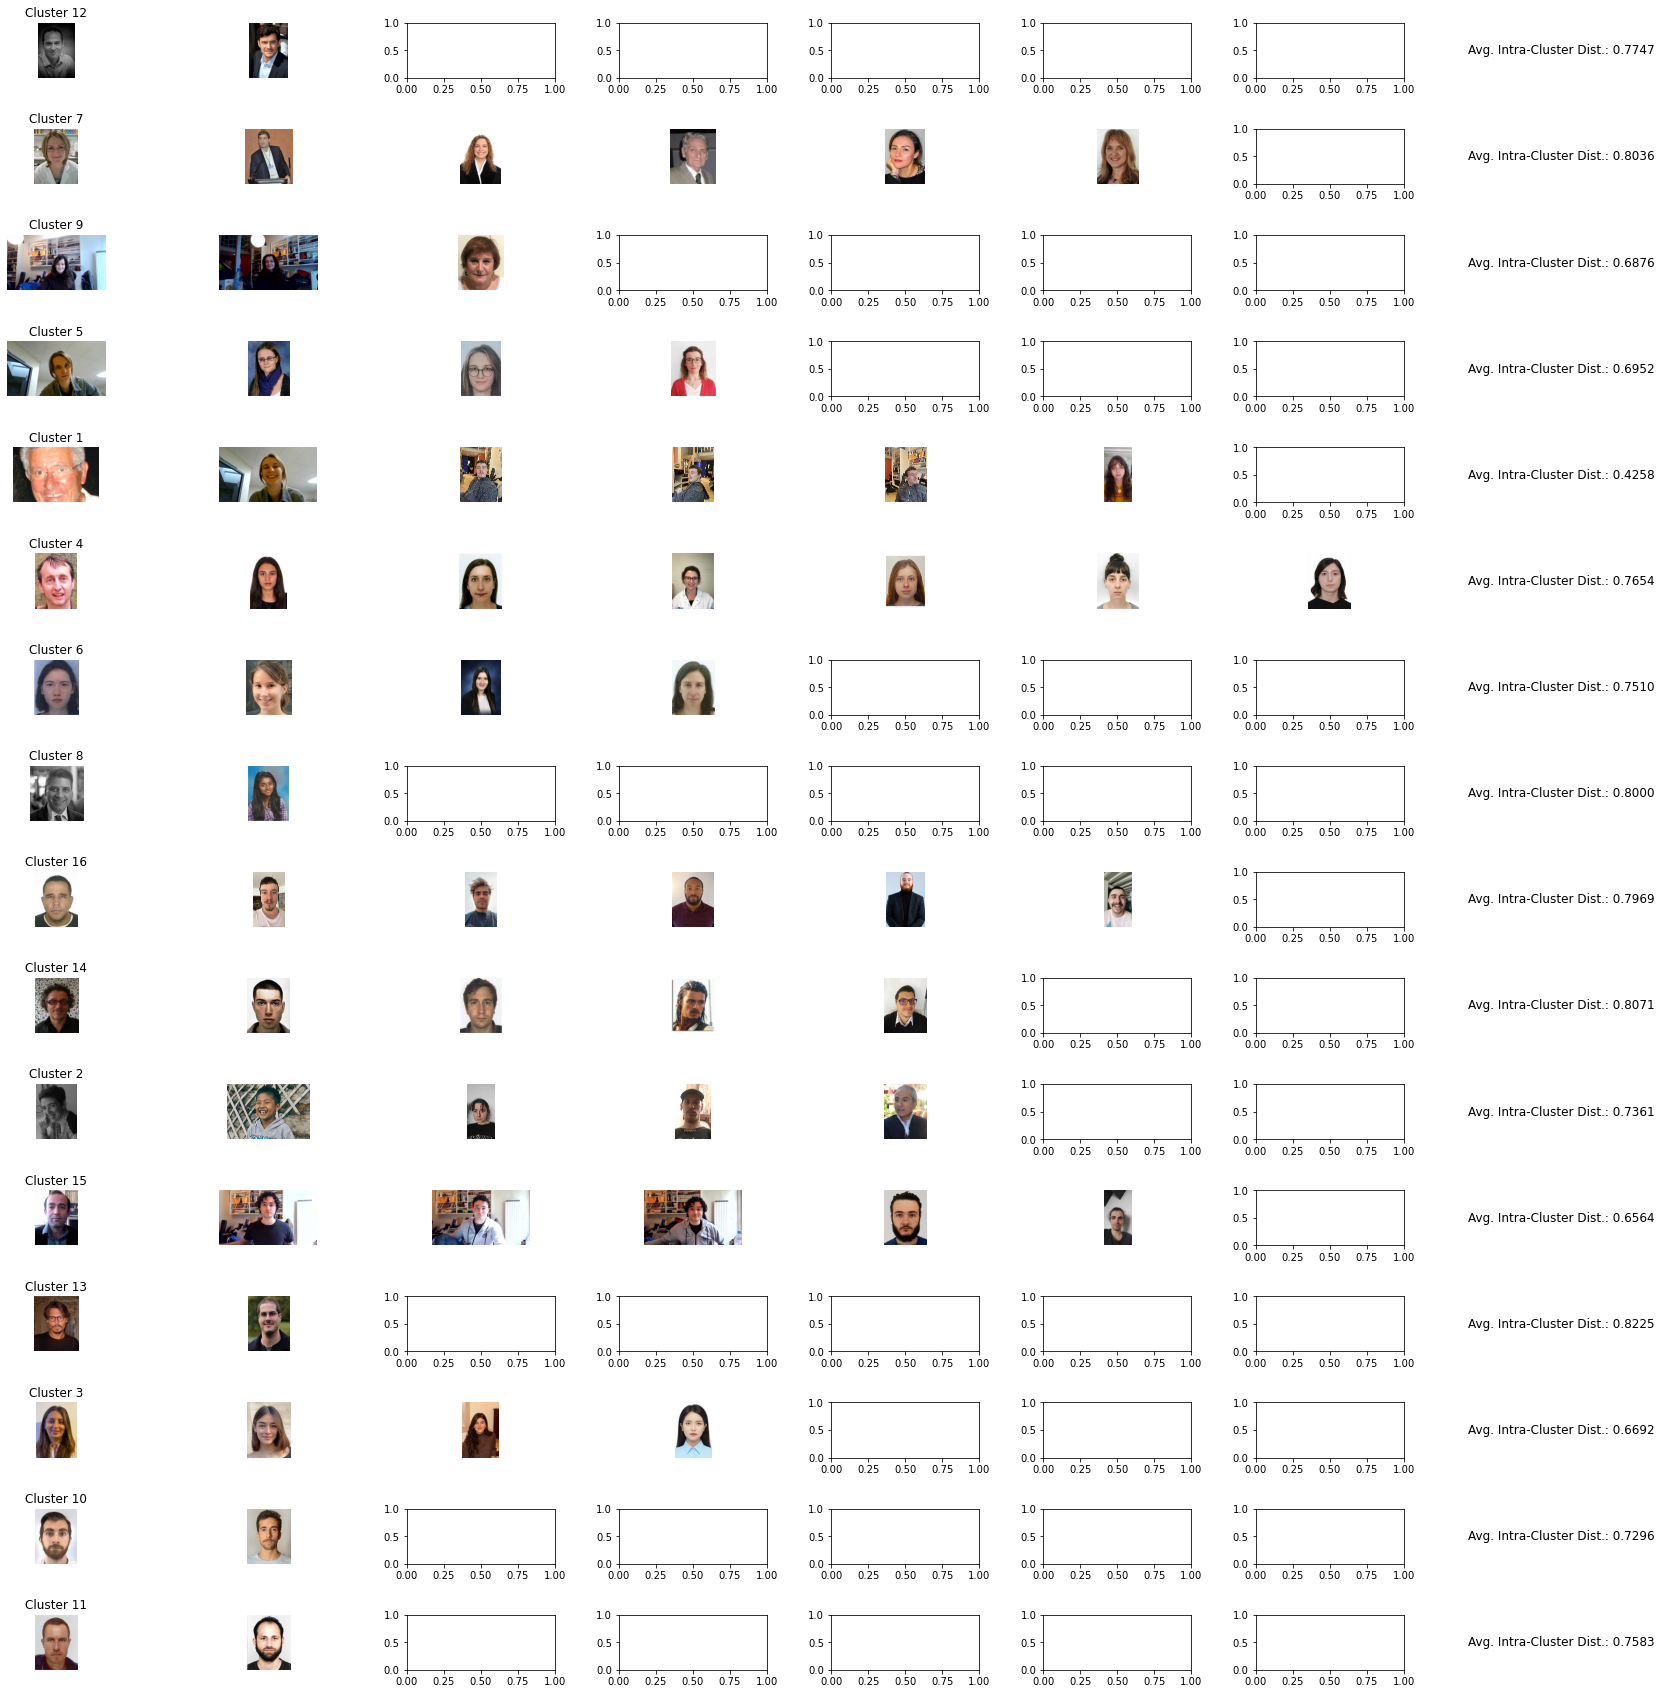

In [62]:
import pandas as pd
import seaborn as sns
import scipy.cluster.hierarchy as hc
import matplotlib.pyplot as plt
import os

# Assuming 'distance_matrix' is your precomputed cosine distance matrix as a pandas DataFrame
# 'image_paths' is a list containing paths to the images corresponding to the rows of 'distance_matrix'
# 'num_clusters' is the desired number of clusters

# Convert the distance matrix from square to condensed form
condensed_distance = sp.distance.squareform(distance_matrix)

# Compute the linkage matrix
linkage = hc.linkage(condensed_distance, method="ward")

# Retrieve clusters by cutting the dendrogram at a specified number of clusters
num_clusters = 16  # Set your desired number of clusters here
clusters = hc.fcluster(linkage, t=num_clusters, criterion='maxclust')

# Group image paths based on cluster assignments
cluster_paths = {}
for i, cluster_id in enumerate(clusters):
    if cluster_id not in cluster_paths:
        cluster_paths[cluster_id] = []
    cluster_paths[cluster_id].append(image_paths[i])

# Plot images for each cluster
num_cols = 7  # Set the number of columns for images in each cluster plot
fig, axes = plt.subplots(num_clusters, num_cols+1, figsize=(24, 24))
fig.tight_layout(pad=3.0)

for i, (cluster_id, paths) in enumerate(cluster_paths.items()):
    ax_row = axes[i] if num_clusters > 1 else axes
    ax_row[0].set_title(f"Cluster {cluster_id}")
    
    # Calculate average distance for the cluster
    intra_cluster_distances = []
    for path1 in paths:
        for path2 in paths:
            if path1 != path2:
                intra_cluster_distances.append(distance_matrix.loc[path1, path2])
    avg_distance = sum(intra_cluster_distances) / len(intra_cluster_distances)
    
    # Plot images
    for j, path in enumerate(paths[:num_cols]):  # Plot only a subset of images per cluster
        img = plt.imread(path)
        ax = ax_row[j]
        ax.imshow(img)
        ax.axis('off')
        # Adjust image size
        ax.set_aspect('equal')  # Ensure aspect ratio is preserved

    # Add legend with average distance
    legend_text = f"Avg. Intra-Cluster Dist.: {avg_distance:.4f}"
    axes[i, -1].text(0, 0.5, legend_text, ha='left', va='center', fontsize=12, transform=axes[i, -1].transAxes)
    axes[i, -1].axis('off')

plt.show()


In [ ]:
#The following is to retrieve images and convert them to .jpg format

In [38]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import time

# Setup service to use ChromeDriverManager
service = Service(executable_path=ChromeDriverManager().install())

# Initialize ChromeOptions
options = webdriver.ChromeOptions()
# Add arguments to options if necessary
options.add_argument('--headless')  # Example: run headless Chrome
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

# Instantiate the Chrome webdriver with the specified service and options
driver = webdriver.Chrome(service=service, options=options)

# Your URL
url = 'https://www.i3-immuno.fr/en/#i3'
driver.get(url)

# Wait for dynamic content to load
time.sleep(5)

# Parse the page source with BeautifulSoup
soup = BeautifulSoup(driver.page_source, 'html.parser')

# Example: find and print specific links
links = soup.find_all('a', href=lambda href: href and href.startswith('/en/#People/'))
for link in links:
    print(link.get('href'))

driver.quit()


/en/#People/LEAD
/en/#People/CA
/en/#People/CEAL
/en/#People/MABI
/en/#People/BBO
/en/#People/PC
/en/#People/PAC
/en/#People/NICO
/en/#People/MCM
/en/#People/GDJ
/en/#People/MDT
/en/#People/HIDE
/en/#People/VDI
/en/#People/AUDO
/en/#People/JODU
/en/#People/PEL
/en/#People/GF
/en/#People/DUGA
/en/#People/BG
/en/#People/SGD
/en/#People/SHA
/en/#People/SIH
/en/#People/MOIS
/en/#People/DK
/en/#People/GKV
/en/#People/AULE
/en/#People/XLI
/en/#People/RL
/en/#People/AMD
/en/#People/FM
/en/#People/EMF
/en/#People/CMA
/en/#People/VMH
/en/#People/ADMI
/en/#People/MAMO
/en/#People/AM
/en/#People/MANA
/en/#People/ONT
/en/#People/MAPE
/en/#People/PRE
/en/#People/JARO
/en/#People/MR
/en/#People/DS
/en/#People/THSA
/en/#People/AS
/en/#People/PST
/en/#People/NTC
/en/#People/STH
/en/#People/VTV
/en/#People/HVA
/en/#People/MAVA
/en/#People/MVG
/en/#People/JAVI
/en/#People/ZZI
/en/#People/DK
/en/#People/ID


In [42]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import requests
import os
from urllib.parse import urljoin

# Your initial URL
base_url = 'https://www.i3-immuno.fr/en/#i3'

# Setup Selenium WebDriver
service = Service(ChromeDriverManager().install())
options = webdriver.ChromeOptions()
options.add_argument('--headless')
driver = webdriver.Chrome(service=service, options=options)

# Specify the folder to save images
save_folder = 'i3_people'

# Ensure the save folder exists
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

# Function to download and save an image
def download_image(image_url, filename):
    response = requests.get(image_url, stream=True)
    if response.status_code == 200:
        with open(os.path.join(save_folder, filename), 'wb') as file:
            for chunk in response.iter_content(1024):
                file.write(chunk)

# Function to generate a valid filename from a URL
def generate_filename_from_url(url):
    # Generate a file name here based on the URL or any other logic
    filename = url.split('/')[-1]  # Simple example, might need more logic for uniqueness
    return filename if filename.endswith('.png') else filename + '.png'

# Assuming links is a list of relative URLs
for href in links:  # links contains the relative URLs
    href = href.get('href')
    full_url = urljoin(base_url, href)
    driver.get(full_url)
    print(full_url)
    time.sleep(30)
    # Find all image tags on the page
    images = driver.find_elements(By.TAG_NAME, 'img')
    
    for img in images:
        img_url = img.get_attribute('src')
        if img_url: #and img_url.endswith('.png'):  # Ensure the src attribute exists and ends with .png
            if 'People' in img_url:
                filename = generate_filename_from_url(img_url)
                download_image(img_url, filename)
                print(f"Downloaded image as {filename} from {img_url}")
            else:
                print('not a person')

driver.quit()


https://www.i3-immuno.fr/en/#People/LEAD
Downloaded image as LEAD01.png from https://www.i3-immuno.fr/Picture%20library/People/LEAD01.png
not a person
not a person
https://www.i3-immuno.fr/en/#People/CA
not a person
https://www.i3-immuno.fr/en/#People/CEAL
Downloaded image as CEAL01.png from https://www.i3-immuno.fr/Picture%20library/People/CEAL01.png
not a person
not a person
https://www.i3-immuno.fr/en/#People/MABI
not a person
not a person
https://www.i3-immuno.fr/en/#People/BBO
Downloaded image as BBO01.png from https://www.i3-immuno.fr/Picture%20library/People/BBO01.png
not a person
not a person
https://www.i3-immuno.fr/en/#People/PC
Downloaded image as PC01.JPG.png from https://www.i3-immuno.fr/Picture%20library/People/PC01.JPG
not a person
not a person
not a person
not a person
https://www.i3-immuno.fr/en/#People/PAC
Downloaded image as PAC01.jpg.png from https://www.i3-immuno.fr/Picture%20library/People/PAC01.jpg
not a person
not a person
not a person
https://www.i3-immuno.fr/e

In [44]:
from PIL import Image
import os

# Specify the folder containing .png images
source_folder = './i3_people'
# Specify the folder to save .jpg images
target_folder = './i3_people_jpg'

# Ensure the target folder exists
if not os.path.exists(target_folder):
    os.makedirs(target_folder)

# Loop through all files in the source folder
for file_name in os.listdir(source_folder):
    if file_name.endswith('.png') or file_name.endswith('.jpg'):
        # File path
        file_path = os.path.join(source_folder, file_name)
        # Open the image
        img = Image.open(file_path)
        # Convert the image to RGB format to ensure compatibility with JPG
        img = img.convert('RGB')
        # Create the .jpg version of the file name
        target_file_name = os.path.splitext(file_name)[0] + '.jpg'
        target_file_path = os.path.join(target_folder, target_file_name)
        # Save the image in .jpg format
        img.save(target_file_path, 'JPEG')
        print(f"Converted {file_name} to {target_file_name}")

print("Conversion completed.")


Converted AM01.png to AM01.jpg
Converted AMD01.png to AMD01.jpg
Converted AS04.jpg.png to AS04.jpg.jpg
Converted AUDO01.png to AUDO01.jpg
Converted AULE01.jpg.png to AULE01.jpg.jpg
Converted BBO01.png to BBO01.jpg
Converted BG01.png to BG01.jpg
Converted CEAL01.png to CEAL01.jpg
Converted CMA01.png to CMA01.jpg
Converted DK01.jpg.png to DK01.jpg.jpg
Converted DS01.png to DS01.jpg
Converted EMF06.jpg.png to EMF06.jpg.jpg
Converted GDJ001.jpg.png to GDJ001.jpg.jpg
Converted GF01.png to GF01.jpg
Converted GKV01.png to GKV01.jpg
Converted HIDE01.png to HIDE01.jpg
Converted HVA01.png to HVA01.jpg
Converted JAVI01.jpg.png to JAVI01.jpg.jpg
Converted JODU01.png to JODU01.jpg
Converted LEAD01.png to LEAD01.jpg
Converted MAMO01.png to MAMO01.jpg
Converted MANA01.jpg.png to MANA01.jpg.jpg
Converted MAVA01.jpg.png to MAVA01.jpg.jpg
Converted MCM01.png to MCM01.jpg
Converted MDT01.png to MDT01.jpg
Converted MOIS01.jpg.png to MOIS01.jpg.jpg
Converted MPE01.png to MPE01.jpg
Converted MR01.png to MR0